In [1]:
import os
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
import torch
import torchvision
import torch.nn as nn
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader

In [2]:
class SurfaceDefectDataset(Dataset):
    def __init__(self, root_dir):
        self.transform = transforms.Compose([transforms.ToTensor()])
        img_files = os.listdir(root_dir)
        self.defect_types = []
        self.images = []
        index = 0
        for file_name in img_files:
            defect_attrs = file_name.split("_")
            d_index = defect_labels.index(defect_attrs[0])
            self.images.append(os.path.join(root_dir, file_name))
            self.defect_types.append(d_index)
            index += 1

    def __len__(self):
        return len(self.images)

    def num_of_samples(self):
        return len(self.images)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
            image_path = self.images[idx]
        else:
            image_path = self.images[idx]
        img = cv.imread(image_path)  # BGR order
        h, w, c = img.shape
        img = cv.resize(img, (200, 200))
        img = (np.float32(img) / 255.0 - 0.5) / 0.5
        img = img.transpose((2, 0, 1))
        sample = {'image': torch.from_numpy(img), 'defect': self.defect_types[idx]}
        return sample

In [3]:
defect_labels = ["Cr", "In", "Pa", "PS", "RS", "Sc"]

In [4]:
train_on_gpu = torch.cuda.is_available()
print(train_on_gpu)

True


In [5]:
class SurfaceDefectResNet(torch.nn.Module):
    def __init__(self):
        super(SurfaceDefectResNet, self).__init__()
        self.cnn_layers = torchvision.models.resnet18(pretrained=True)
        num_ftrs = self.cnn_layers.fc.in_features
        self.cnn_layers.fc = nn.Linear(num_ftrs, 6)

    def forward(self, x):
        out = self.cnn_layers(x)
        return out

In [6]:
train_dataset = SurfaceDefectDataset("C:\\Users\\15588\\Desktop\\CLS-train")

In [7]:
train_data_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)

In [8]:
model = SurfaceDefectResNet()

In [9]:
cross_loss = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)

In [10]:
num_epochs = 50
epoch_loss = {}
model.train()
for epoch in range(num_epochs):
    index = 0
    train_loss = 0
    for i_batch, sample_batched in enumerate(train_data_loader):
        images_batch, label_batch = sample_batched['image'], sample_batched['defect']
        if train_on_gpu:
            model.cuda()
            images_batch, label_batch= images_batch.cuda(), label_batch.cuda()
        optimizer.zero_grad()
        m_label_out_ = model(images_batch)
        label_batch = label_batch.long()
        loss = cross_loss(m_label_out_, label_batch)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        index += 1
    mean_loss = train_loss/index
    epoch_loss[epoch+1] = mean_loss
    print('epoch: {} \tTraining Loss: {:.6f} '.format(epoch+1, mean_loss))

epoch: 1 	Training Loss: 1.646487 
epoch: 2 	Training Loss: 0.725992 
epoch: 3 	Training Loss: 0.655372 
epoch: 4 	Training Loss: 0.675960 
epoch: 5 	Training Loss: 0.589205 
epoch: 6 	Training Loss: 0.521851 
epoch: 7 	Training Loss: 0.592447 
epoch: 8 	Training Loss: 0.355609 
epoch: 9 	Training Loss: 0.299400 
epoch: 10 	Training Loss: 0.540889 
epoch: 11 	Training Loss: 0.337082 
epoch: 12 	Training Loss: 0.259984 
epoch: 13 	Training Loss: 0.251574 
epoch: 14 	Training Loss: 0.178628 
epoch: 15 	Training Loss: 0.186943 
epoch: 16 	Training Loss: 0.461932 
epoch: 17 	Training Loss: 0.238348 
epoch: 18 	Training Loss: 0.158727 
epoch: 19 	Training Loss: 0.141373 
epoch: 20 	Training Loss: 0.144336 
epoch: 21 	Training Loss: 0.110605 
epoch: 22 	Training Loss: 0.165707 
epoch: 23 	Training Loss: 0.133974 
epoch: 24 	Training Loss: 0.112219 
epoch: 25 	Training Loss: 0.082373 
epoch: 26 	Training Loss: 0.117185 
epoch: 27 	Training Loss: 0.124655 
epoch: 28 	Training Loss: 0.079812 
e

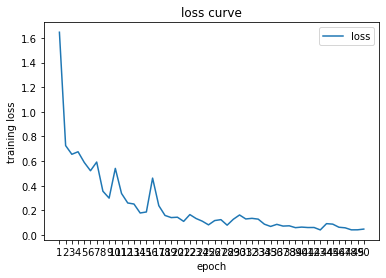

In [11]:
x = [i for i in epoch_loss.keys()]
y = [i for i in epoch_loss.values()]
plt.title("loss curve")
plt.xlabel("epoch")
plt.ylabel("training loss")
plt.xticks(x)
plt.plot(x, y, label="loss")
plt.legend()

In [12]:
test_dataset = SurfaceDefectDataset("C:\\Users\\15588\\Desktop\\CLS-test")

In [13]:
test_data_loader = torch.utils.data.DataLoader(test_dataset, batch_size=1, shuffle=False)

In [14]:
model.eval()
softmax = nn.Softmax(dim=0)
for i_batch, sample_batched in enumerate(test_data_loader):
    images_batch, label_batch = sample_batched['image'], sample_batched['defect']
    true_label = defect_labels[label_batch.item()]
    print("当前图片中的缺陷为：" + str(true_label))
    if train_on_gpu:
        model.cuda()
        images_batch, label_batch= images_batch.cuda(), label_batch.cuda()
    output = model(images_batch)
    output = output.squeeze(0)
    output = softmax(output)
    output_list = output.tolist()
    index = output_list.index(max(output_list))
    predict_label = defect_labels[index]
    print("预测当前图片中的缺陷为：" + str(predict_label))
    print('\n')

当前图片中的缺陷为：Cr
预测当前图片中的缺陷为：Cr


当前图片中的缺陷为：Cr
预测当前图片中的缺陷为：Cr


当前图片中的缺陷为：Cr
预测当前图片中的缺陷为：Cr


当前图片中的缺陷为：Cr
预测当前图片中的缺陷为：Cr


当前图片中的缺陷为：Cr
预测当前图片中的缺陷为：Cr


当前图片中的缺陷为：Cr
预测当前图片中的缺陷为：Cr


当前图片中的缺陷为：Cr
预测当前图片中的缺陷为：Cr


当前图片中的缺陷为：Cr
预测当前图片中的缺陷为：Cr


当前图片中的缺陷为：Cr
预测当前图片中的缺陷为：Cr


当前图片中的缺陷为：Cr
预测当前图片中的缺陷为：Cr


当前图片中的缺陷为：Cr
预测当前图片中的缺陷为：Cr


当前图片中的缺陷为：Cr
预测当前图片中的缺陷为：Cr


当前图片中的缺陷为：In
预测当前图片中的缺陷为：In


当前图片中的缺陷为：In
预测当前图片中的缺陷为：In


当前图片中的缺陷为：In
预测当前图片中的缺陷为：In


当前图片中的缺陷为：In
预测当前图片中的缺陷为：In


当前图片中的缺陷为：In
预测当前图片中的缺陷为：In


当前图片中的缺陷为：In
预测当前图片中的缺陷为：In


当前图片中的缺陷为：In
预测当前图片中的缺陷为：In


当前图片中的缺陷为：In
预测当前图片中的缺陷为：In


当前图片中的缺陷为：In
预测当前图片中的缺陷为：In


当前图片中的缺陷为：In
预测当前图片中的缺陷为：Sc


当前图片中的缺陷为：In
预测当前图片中的缺陷为：In


当前图片中的缺陷为：In
预测当前图片中的缺陷为：In


当前图片中的缺陷为：Pa
预测当前图片中的缺陷为：Pa


当前图片中的缺陷为：Pa
预测当前图片中的缺陷为：Pa


当前图片中的缺陷为：Pa
预测当前图片中的缺陷为：Pa


当前图片中的缺陷为：Pa
预测当前图片中的缺陷为：Pa


当前图片中的缺陷为：Pa
预测当前图片中的缺陷为：Pa


当前图片中的缺陷为：Pa
预测当前图片中的缺陷为：Pa


当前图片中的缺陷为：Pa
预测当前图片中的缺陷为：Pa


当前图片中的缺陷为：Pa
预测当前图片中的缺陷为：Pa


当前图片中的缺陷为：Pa
预测当前图片中的缺陷为：Pa


当前图片中的缺陷为：